In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from read_csv_data import *
from my_filter import *
from my_util import *
from functions_tcga import *
from sklearn.model_selection import cross_val_predict

path_root = './data/'
Y_raw, Y_drug_id, Y_drug_name, tissue_id_list, tissue_name_list, dataset_id, X_gene_symbol_list, X_oncogene_idx = my_load_data(path_root)
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})



## Training parameters
C_cv_fold = 5     # cross-validation fold
flag_oncogene = False    # boolean for oncogene filter
flag_tpm_normalize = False  # boolean for TPM normalization before KNN modeling
flag_tpm_select = True   # boolean for TPM normalization before filtering genes
bool_pca = True
pca_dim = 30

##drug sensitivity threshold
drug_sens_threshold = 3

##drug selected
# drug_selected_name='ALL' 
drug_selected_name='5-FU'    #210
# drug_selected_name='Oxaliplatin'    #82
# drug_selected_name='Cisplatin'    #94
# drug_selected_name='Carboplatin'  #54
# drug_selected_name='Taxol'      #40
# drug_selected_name='Cytoxan'     #59
# drug_selected_name='Cyclophosphamide'    #41
# drug_selected_name='Capecitabine'     #62

##cancer types selected
tissue_1 = 'COAD'
tissue_2 = 'STAD'
tissue_3 = 'ESCA'
tissue_4 = 'LUAD'
tissue_5 = 'READ'
tissue_6 = 'BRCA'

# gene_symbol_list
gene_symbol_path = path_root + 'rnaseq_gene_symbol.csv'
gene_symbol_list = np.array(read_csv_data(gene_symbol_path,firstline=False))[:,2].T

the_label = ['COAD','STAD','ESCA','LUAD','READ','BRCA']
the_color = ['black','tomato','yellowgreen','sandybrown','royalblue','darkcyan']

In [5]:
# #############################################################################
# ## load data ## only once
X_coad, f_coad,u_coad,y_coad = my_load_data_tcga(tissue_1,drug_selected_name)

X_stad, f_stad,u_stad,y_stad = my_load_data_tcga(tissue_2,drug_selected_name)

X_esca, f_esca,u_esca,y_esca = my_load_data_tcga(tissue_3,drug_selected_name)

X_luad, f_luad,u_luad,y_luad = my_load_data_tcga(tissue_4,drug_selected_name)

X_read, f_read,u_read,y_read = my_load_data_tcga(tissue_5,drug_selected_name)

X_brca, f_brca,u_brca,y_brca = my_load_data_tcga(tissue_6,drug_selected_name)

# ##############################################################################

FKPM file 8 mismatch deleted
FKPM file 21 mismatch deleted
FKPM file 2 mismatch deleted
FKPM file 3 mismatch deleted
FKPM file 6 mismatch deleted
FKPM file 14 mismatch deleted
FKPM file 15 mismatch deleted
FKPM file 17 mismatch deleted
FKPM file 18 mismatch deleted
FKPM file 19 mismatch deleted
FKPM file 21 mismatch deleted
FKPM file 23 mismatch deleted
FKPM file 25 mismatch deleted
FKPM file 28 mismatch deleted
FKPM file 31 mismatch deleted
FKPM file 36 mismatch deleted
FKPM file 40 mismatch deleted
FKPM file 41 mismatch deleted
FKPM file 47 mismatch deleted
FKPM file 48 mismatch deleted
FKPM file 49 mismatch deleted


shape_X (1386, 21966) 
shape_y 1386
tissue id mapping
(1386, 21966)
sum(pca.explained_variance_ratio_) 0.6755346447762476
(1386, 30)
(1386, 2)


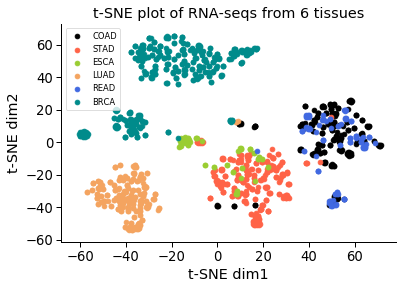

0

In [3]:
## t-sne mapping of RNA-seqs for samples from 6 cancer types, pca + tsne

# get training dataset X y
X=np.r_[X_coad,X_stad,X_esca,X_luad,X_read,X_brca]
y=np.r_[y_coad,y_stad,y_esca,y_luad,y_read,y_brca]
tissue_flag = np.array([0 for _ in range(X_coad.shape[0]) ] + [1 for _ in range(X_stad.shape[0]) ] + [2 for _ in range(X_esca.shape[0]) ]\
               + [3 for _ in range(X_luad.shape[0]) ] + [4 for _ in range(X_read.shape[0]) ] + [5 for _ in range(X_brca.shape[0])])

X,id_list=my_delete_NaN_col(X)
gene_symbol_list = gene_symbol_list[id_list]
print('shape_X',np.shape(X),'\nshape_y',len(y))

flag_fpkm_tpm = True  #TPM normalization

print('tissue id mapping')
title = 't-SNE plot of RNA-seqs from 6 tissues'
my_tsne_RNA(X,tissue_flag,the_label,the_color,title,flag_fpkm_tpm,bool_pca,pca_dim,bool_save=True,save_path='../paper_fig/all_drug_5_tissues_all_gene_tsne_jet')

In [6]:
#load coad+read
X=np.r_[X_coad,X_read]
y=np.r_[y_coad,y_read]
tissue_flag = [0 for _ in range(X_coad.shape[0]) ] + [1 for _ in range(X_read.shape[0]) ]
X,id_list=my_delete_NaN_col(X)
gene_symbol_list = gene_symbol_list[id_list]
print('shape_X',np.shape(X),'\nshape_y',len(y))

shape_X (90, 21966) 
shape_y 90


In [7]:
## gene filtering
if flag_tpm_select:
    X =  fpkm_to_tpm(X)
    
X_before=X    

X_idx = np.array([i for i in range(X.shape[1])])
X_idx_before = X_idx

###### oncogene filter
if flag_oncogene:
    Filter_idx = get_repeating_idx_filter(X_idx, X_oncogene_idx)
    X = X[:, Filter_idx]
    X_idx = X_idx[Filter_idx]
    print('after selection, X:', X.shape)
    
###### expression level filter
Filter_idx = np.argwhere(np.mean(X, axis=0)>1).T[0]
Filter_idx2 = np.argwhere(np.mean(X, axis=0)<=1).T[0]
X = X[:, Filter_idx]
X_idx = X_idx[Filter_idx]
print('after mean, X:', X.shape)

###### mann-whitneyutest filter 
Filter_idx, Filter_up = get_utest_filter(X,y,drug_sens_threshold,1)
X = X[:, Filter_idx]
X_idx = X_idx[Filter_idx]
print('after utest filter (p_value), X:',X.shape)


Filter_score_general = -Filter_up

## gene scoring and rating
Filter_score_sorted_idx = sorted(range(X.shape[1]), key=lambda k: Filter_score_general[k], reverse=True)
Filter_score_sorted = Filter_score_general[Filter_score_sorted_idx]

after mean, X: (90, 13281)
after utest filter (p_value), X: (90, 13281)


In [8]:
## knn classification
X_idx_raw=Filter_score_sorted_idx
X_test=np.log(1+X)
Y_test=np.zeros([1,np.size(y,0)])
Y_test[0,:]=(y>drug_sens_threshold)*1
Y_drug_idx=[0]

# KNN cross-validation for best gene list and parameter k
best_best_mean_auc_score = 0
best_C_selected_para_cnt = 1
    
best_C_selected_para_cnt, best_best_C_neighbor_k = \
get_knn_para_by_bruteforce_TCGA(X_idx_raw, X_test, Y_test, Y_drug_idx, C_cv_fold,  \
                            flag_tpm_normalize, 30, 10, True, 0.02, False)
print(best_C_selected_para_cnt, best_best_C_neighbor_k )

C_selected_para_cnt=10, best_C_neighbor_k=14, Accuracy=0.900000
C_selected_para_cnt=11, best_C_neighbor_k=7, Accuracy=0.888889
C_selected_para_cnt=12, best_C_neighbor_k=11, Accuracy=0.900000
C_selected_para_cnt=13, best_C_neighbor_k=9, Accuracy=0.900000
C_selected_para_cnt=14, best_C_neighbor_k=9, Accuracy=0.900000
C_selected_para_cnt=15, best_C_neighbor_k=9, Accuracy=0.900000
C_selected_para_cnt=16, best_C_neighbor_k=5, Accuracy=0.911111
C_selected_para_cnt=17, best_C_neighbor_k=5, Accuracy=0.888889
C_selected_para_cnt=18, best_C_neighbor_k=5, Accuracy=0.877778
C_selected_para_cnt=19, best_C_neighbor_k=3, Accuracy=0.877778
C_selected_para_cnt=20, best_C_neighbor_k=7, Accuracy=0.900000
C_selected_para_cnt=21, best_C_neighbor_k=8, Accuracy=0.900000
C_selected_para_cnt=22, best_C_neighbor_k=8, Accuracy=0.900000
C_selected_para_cnt=23, best_C_neighbor_k=10, Accuracy=0.888889
C_selected_para_cnt=24, best_C_neighbor_k=8, Accuracy=0.888889
C_selected_para_cnt=25, best_C_neighbor_k=3, Accurac

In [9]:
## according to the previous result
num_of_para=15
best_C_neighbor_k=9
X_idx[Filter_score_sorted_idx][0:num_of_para]

array([18236, 14485, 15944, 21627,  3039, 19546,   111,  4311,  5298,
        2262,  3952,  5721,  1512, 19724,  3670])

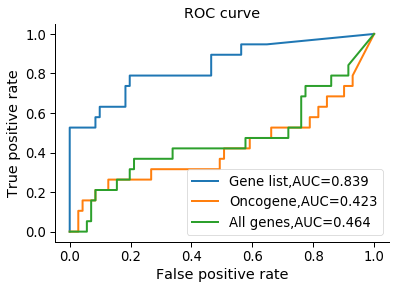

Accuracy score: 0.9

Precision score weighted: 0.9112499999999999
Precision score (class 1): 1.0
Precision score (class 0): 0.8875

Recall/Sensitivity score: 0.5263157894736842
Specificity score: 1.0

F1 score weighted: 0.8874628910710208


In [10]:
## comparing the AUC scores of different gene selections
# gene list
model_knn = KNeighborsClassifier(n_neighbors = best_C_neighbor_k, weights='distance', algorithm = 'auto')

X1=np.log(X[:, Filter_score_sorted_idx[0:num_of_para]]+1)
Y1=(y>drug_sens_threshold)*1
y_pred_proba = cross_val_predict(model_knn, X1, Y1, cv = C_cv_fold,method = 'predict_proba')[:,1]  
y_pred= cross_val_predict(model_knn, X1, Y1, cv = C_cv_fold) 
auc_score = math.nan

## oncogenes
Filter_idx = get_repeating_idx_filter(X_idx_before, X_oncogene_idx)
X2 = np.log(X_before[:, Filter_idx]+1)
y_pred_proba_2 = cross_val_predict(model_knn, X2, Y1, cv = C_cv_fold,method = 'predict_proba')[:,1]  
y_pred_2= cross_val_predict(model_knn, X2, Y1, cv = C_cv_fold) 
auc_score_2 = math.nan

## All genes
X3 = np.log(X_before+1)
y_pred_proba_3 = cross_val_predict(model_knn, X3, Y1, cv = C_cv_fold,method = 'predict_proba')[:,1]  
y_pred_3= cross_val_predict(model_knn, X3, Y1, cv = C_cv_fold) 
auc_score_3 = math.nan

if len(np.unique(Y1)) == 2:
    auc_score = metrics.roc_auc_score(Y1, y_pred_proba)
    fpr, tpr, thresholds = metrics.roc_curve(Y1, y_pred_proba, pos_label=1)
    plt.plot(fpr,tpr,label = 'Gene list,AUC=%0.3f'%auc_score)
    
    auc_score_2 = metrics.roc_auc_score(Y1, y_pred_proba_2)
    fpr, tpr, thresholds = metrics.roc_curve(Y1, y_pred_proba_2, pos_label=1)
    plt.plot(fpr,tpr,label = 'Oncogene,AUC=%0.3f'%auc_score_2)
    
    auc_score_3 = metrics.roc_auc_score(Y1, y_pred_proba_3)
    fpr, tpr, thresholds = metrics.roc_curve(Y1, y_pred_proba_3, pos_label=1)
    plt.plot(fpr,tpr,label = 'All genes,AUC=%0.3f'%auc_score_3)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    sns.despine()
    plt.legend()
    plt.savefig('../paper_fig/best_AUC.eps',format='eps')
    plt.savefig('../paper_fig/best_AUC.png',dpi=600)
    plt.show()
    acc_score = metrics.accuracy_score(Y1,y_pred)
    print('Accuracy score:',acc_score)
    print()
    prec_score = metrics.precision_score(Y1,y_pred,average='weighted')
    print('Precision score weighted:',prec_score)
    prec_score = metrics.precision_score(Y1,y_pred,pos_label=1,average='binary')
    print('Precision score (class 1):',prec_score)
    prec_score = metrics.precision_score(Y1,y_pred,pos_label=0,average='binary')
    print('Precision score (class 0):',prec_score)
    print()
    rec_score = metrics.recall_score(Y1,y_pred,pos_label=1,average='binary')
    print('Recall/Sensitivity score:',rec_score)
    spec_score = metrics.recall_score(Y1,y_pred,pos_label=0,average='binary')
    print('Specificity score:',spec_score)
    print()
    f1_score = metrics.f1_score(Y1,y_pred,average='weighted')
    print('F1 score weighted:',f1_score)

In [11]:
gene_symbol_list = gene_symbol_list[X_idx[Filter_score_sorted_idx][0:num_of_para]]
# np.savetxt('./output/gene_symbol_list_guangzhou_5fu.csv', gene_symbol_list, fmt='%s', delimiter=',')
# np.savetxt('./output/gene_symbol_list_TCGA_5fu.csv', gene_symbol_list, fmt='%s', delimiter=',')
gene_symbol_list

array(['SHPK', 'PAPSS2', 'PRPSAP2', 'XPNPEP1', 'CHP1', 'TAF5', 'ABRAXAS2',
       'DERL2', 'EMP2', 'CACUL1', 'CWF19L1', 'FAS', 'BAG3', 'TCF7L2',
       'CRK'], dtype='<U25')